In [1]:
import pandas as pd
from datetime import datetime
import time
import numpy as np
import pandas as pd
import io

In [2]:
df = pd.read_csv('duk_merge.csv')
# Inspect the data

df['Date'] = df['Datetime'].str[:-6]
df['Date']=pd.to_datetime(df["Date"]).dt.strftime("%Y-%m-%d %H:%M:%S")

In [3]:
data_date = df.filter(['Date'])

data_date = data_date.values
# Get the number of rows to train the model on
training_data_date = int(np.ceil( len(data_date) * .95 ))
train_data_date = data_date[0:int(training_data_date), :]

In [4]:
import tensorflow.keras.layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, Activation, Conv1D
from tensorflow.keras.layers import Dense, Input, RNN
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [5]:

import tensorflow as tf
print(tf.__version__)

2.8.0


In [6]:
data = pd.DataFrame()
data['Close']=df['Close']
count_nan = len(df) - df.count()
print(count_nan)

Datetime     0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Date         0
dtype: int64


In [7]:
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
# training_data_len = math.ceil( len(dataset) *.6)
training_data_len = math.ceil( len(dataset)*.95) 



#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)


#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])


#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)    


#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [8]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])



#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [9]:
dataDimension = int(x_train.shape[1]) 

In [10]:
cell = "FastRNN" 
 
inputDims = 1 #features taken in by RNN in one timestep
hiddenDims = 50 #hidden state of RNN
 
totalEpochs = 8
batchSize = 64
 
learningRate = 0.001 
decayStep = 50
decayRate = 0.1
 
outFile = None
 

wRank = None 
uRank = None 
 

sW = 1.0 
sU = 1.0
 
#Non-linearities for the RNN architecture. Can choose from "tanh, sigmoid, relu, quantTanh, quantSigm"
update_non_linearity = "relu"
gate_non_linearity = "relu"


cell == "FastRNN"

True

In [11]:
print(x_train.shape)
x_train = np.reshape(x_train,[x_train.shape[0],x_train.shape[1],1])
print(x_test.shape)
x_test = np.reshape(x_test,[x_test.shape[0],x_test.shape[1],1])
print(x_train.shape)
print(x_test.shape)

(6594, 60, 1)
(350, 60, 1)
(6594, 60, 1)
(350, 60, 1)


In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

#Initialize RNN:
regressor = Sequential()

#Adding the first RNN layer and some Dropout regularization
regressor.add(SimpleRNN(units = 50, activation='tanh', return_sequences=True, input_shape= (x_train.shape[1],1)))
regressor.add(Conv1D(filters=300, kernel_size=3 , padding='same', activation='relu', name='Conv1D'))
regressor.add(MaxPooling1D(pool_size=1,name='MaxPooling1D'))


#Adding the second RNN layer and some Dropout regularization
regressor.add(Bidirectional(LSTM(units=50, return_sequences=False)))
regressor.add(Dense(1))
# Compile the model
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
regressor.fit(x_train, y_train, batch_size=64, epochs=8)


Epoch 1/8
104/104 [==============================] - 19s 127ms/step - loss: 0.0094
Epoch 2/8
104/104 [==============================] - 24s 230ms/step - loss: 2.0912e-04
Epoch 3/8
104/104 [==============================] - 25s 246ms/step - loss: 1.5882e-04
Epoch 4/8
104/104 [==============================] - 30s 288ms/step - loss: 1.6177e-04
Epoch 5/8
104/104 [==============================] - 34s 331ms/step - loss: 1.1454e-04
Epoch 6/8
104/104 [==============================] - 25s 238ms/step - loss: 1.4634e-04
Epoch 7/8
104/104 [==============================] - 26s 247ms/step - loss: 1.3236e-04
Epoch 8/8
104/104 [==============================] - 23s 222ms/step - loss: 1.0950e-04


In [15]:
# Get the models predicted price values 
predictions = regressor.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse


0.3033478609388063

In [16]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

train = data[:training_data_len]
valid_3 = data[training_data_len:]
valid_3['Predictions'] = predictions

mape(valid_3['Close'], valid_3['Predictions'])

<ipython-input-16-ffc677cae395>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_3['Predictions'] = predictions


0.28950357385597963

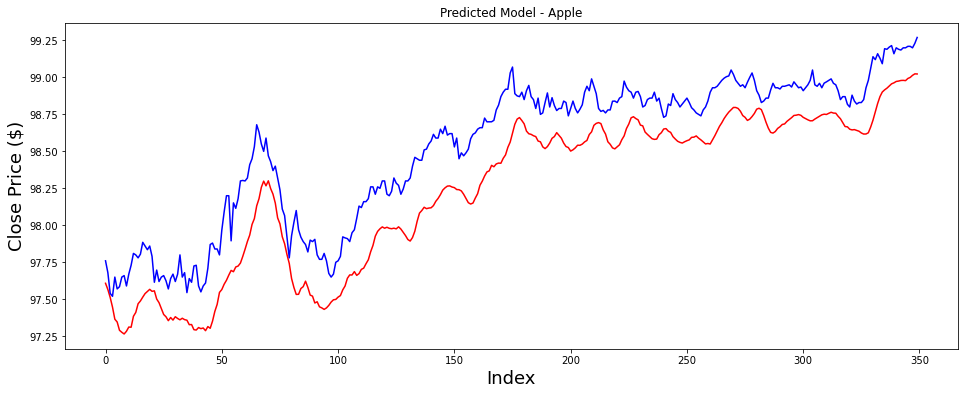

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.title('Predicted Model - Apple')
plt.xlabel('Index', fontsize=18)
plt.ylabel('Close Price ($)', fontsize=18)
#plt.plot(train['Close'], 'b-', label = 'train')
plt.plot(predictions,'r-', label = 'predict')
plt.plot(y_test,'b-', label = 'actual')
#plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()